# Imports

In [1]:
import shap
import optuna

import numpy   as np
import pandas  as pd
import seaborn as sns
import category_encoders as ce

import matplotlib.pyplot as plt

from xgboost  import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from feature_engine import encoding
from feature_engine import creation
from feature_engine import imputation

from sklearn.metrics           import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectFromModel

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Functions

In [2]:
random_state = 42
np.random.seed(random_state)

In [3]:
def jupyter_settings():
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 500

jupyter_settings()

In [4]:
def get_metrics(y_true, y_pred):

    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"R2: {r2}; RMSE: {rmse}; MAE: {mae}; MAPE: {mape}")

# Loading Datasets

In [5]:
df_train = pd.read_parquet('../data/processed/df_train_from_2.1_exploratory_data_analysis.parquet')
df_valid = pd.read_parquet('../data/processed/df_valid_from_2.1_exploratory_data_analysis.parquet')
df_oot = pd.read_parquet('../data/processed/df_oot_from_2.1_exploratory_data_analysis.parquet')

## Columns

In [6]:
df_train.columns.tolist()

['order_purchase_timestamp',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'customer_lat',
 'customer_lng',
 'seller_geolocation_city_count',
 'seller_geolocation_city_nunique',
 'seller_geolocation_city_size',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_count',
 'seller_geolocation_state_nunique',
 'seller_geolocation_state_size',
 'seller_geolocation_state_mode',
 'distance_customer_seller_count',
 'distance_customer_seller_min',
 'distance_customer_seller_max',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'distance_customer_seller_range',
 'payment_sequential_count',
 'payment_sequential_min',
 'payment_sequential_max',
 'payment_sequential_mean',
 'payment_sequential_median',
 'payment_sequential_q25',
 'payment_sequential_q75',
 'payment_sequential_range',
 'payment_type_count',
 'paymen

In [7]:
df_valid.columns.tolist()

['order_purchase_timestamp',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'customer_lat',
 'customer_lng',
 'seller_geolocation_city_count',
 'seller_geolocation_city_nunique',
 'seller_geolocation_city_size',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_count',
 'seller_geolocation_state_nunique',
 'seller_geolocation_state_size',
 'seller_geolocation_state_mode',
 'distance_customer_seller_count',
 'distance_customer_seller_min',
 'distance_customer_seller_max',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'distance_customer_seller_range',
 'payment_sequential_count',
 'payment_sequential_min',
 'payment_sequential_max',
 'payment_sequential_mean',
 'payment_sequential_median',
 'payment_sequential_q25',
 'payment_sequential_q75',
 'payment_sequential_range',
 'payment_type_count',
 'paymen

In [8]:
df_oot.columns.tolist()

['order_purchase_timestamp',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'customer_lat',
 'customer_lng',
 'seller_geolocation_city_count',
 'seller_geolocation_city_nunique',
 'seller_geolocation_city_size',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_count',
 'seller_geolocation_state_nunique',
 'seller_geolocation_state_size',
 'seller_geolocation_state_mode',
 'distance_customer_seller_count',
 'distance_customer_seller_min',
 'distance_customer_seller_max',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'distance_customer_seller_range',
 'payment_sequential_count',
 'payment_sequential_min',
 'payment_sequential_max',
 'payment_sequential_mean',
 'payment_sequential_median',
 'payment_sequential_q25',
 'payment_sequential_q75',
 'payment_sequential_range',
 'payment_type_count',
 'paymen

## Data Dimensions

In [9]:
print('Number of Rows: {}'.format(df_train.shape[0]))
print('Number of Cols: {}'.format(df_train.shape[1]))

Number of Rows: 52161
Number of Cols: 147


In [10]:
print('Number of Rows: {}'.format(df_valid.shape[0]))
print('Number of Cols: {}'.format(df_valid.shape[1]))

Number of Rows: 25692
Number of Cols: 147


In [11]:
print('Number of Rows: {}'.format(df_oot.shape[0]))
print('Number of Cols: {}'.format(df_oot.shape[1]))

Number of Rows: 18603
Number of Cols: 147


## Data Types

In [12]:
df_train.dtypes

order_purchase_timestamp                    datetime64[ns]
order_delivered_customer_date               datetime64[ns]
order_estimated_delivery_date               datetime64[ns]
customer_zip_code_prefix                            object
customer_city                                       object
customer_state                                      object
customer_lat                                       float64
customer_lng                                       float64
seller_geolocation_city_count                        int64
seller_geolocation_city_nunique                      int64
seller_geolocation_city_size                         int64
seller_geolocation_city_mode                        object
seller_geolocation_state_count                       int64
seller_geolocation_state_nunique                     int64
seller_geolocation_state_size                        int64
seller_geolocation_state_mode                       object
distance_customer_seller_count                       int

In [13]:
df_valid.dtypes

order_purchase_timestamp                    datetime64[ns]
order_delivered_customer_date               datetime64[ns]
order_estimated_delivery_date               datetime64[ns]
customer_zip_code_prefix                            object
customer_city                                       object
customer_state                                      object
customer_lat                                       float64
customer_lng                                       float64
seller_geolocation_city_count                        int64
seller_geolocation_city_nunique                      int64
seller_geolocation_city_size                         int64
seller_geolocation_city_mode                        object
seller_geolocation_state_count                       int64
seller_geolocation_state_nunique                     int64
seller_geolocation_state_size                        int64
seller_geolocation_state_mode                       object
distance_customer_seller_count                       int

In [14]:
df_oot.dtypes

order_purchase_timestamp                    datetime64[ns]
order_delivered_customer_date               datetime64[ns]
order_estimated_delivery_date               datetime64[ns]
customer_zip_code_prefix                            object
customer_city                                       object
customer_state                                      object
customer_lat                                       float64
customer_lng                                       float64
seller_geolocation_city_count                        int64
seller_geolocation_city_nunique                      int64
seller_geolocation_city_size                         int64
seller_geolocation_city_mode                        object
seller_geolocation_state_count                       int64
seller_geolocation_state_nunique                     int64
seller_geolocation_state_size                        int64
seller_geolocation_state_mode                       object
distance_customer_seller_count                       int

## Check NA

In [15]:
df_train.isna().mean()

order_purchase_timestamp                    0.000000
order_delivered_customer_date               0.000000
order_estimated_delivery_date               0.000000
customer_zip_code_prefix                    0.000000
customer_city                               0.000000
customer_state                              0.000000
customer_lat                                0.002799
customer_lng                                0.002799
seller_geolocation_city_count               0.000000
seller_geolocation_city_nunique             0.000000
seller_geolocation_city_size                0.000000
seller_geolocation_city_mode                0.002492
seller_geolocation_state_count              0.000000
seller_geolocation_state_nunique            0.000000
seller_geolocation_state_size               0.000000
seller_geolocation_state_mode               0.002511
distance_customer_seller_count              0.000000
distance_customer_seller_min                0.005272
distance_customer_seller_max                0.

In [16]:
df_valid.isna().mean()

order_purchase_timestamp                    0.000000
order_delivered_customer_date               0.000000
order_estimated_delivery_date               0.000000
customer_zip_code_prefix                    0.000000
customer_city                               0.000000
customer_state                              0.000000
customer_lat                                0.002491
customer_lng                                0.002491
seller_geolocation_city_count               0.000000
seller_geolocation_city_nunique             0.000000
seller_geolocation_city_size                0.000000
seller_geolocation_city_mode                0.002335
seller_geolocation_state_count              0.000000
seller_geolocation_state_nunique            0.000000
seller_geolocation_state_size               0.000000
seller_geolocation_state_mode               0.002335
distance_customer_seller_count              0.000000
distance_customer_seller_min                0.004787
distance_customer_seller_max                0.

In [17]:
df_oot.isna().mean()

order_purchase_timestamp                    0.000000
order_delivered_customer_date               0.000000
order_estimated_delivery_date               0.000000
customer_zip_code_prefix                    0.000000
customer_city                               0.000000
customer_state                              0.000000
customer_lat                                0.002903
customer_lng                                0.002903
seller_geolocation_city_count               0.000000
seller_geolocation_city_nunique             0.000000
seller_geolocation_city_size                0.000000
seller_geolocation_city_mode                0.001398
seller_geolocation_state_count              0.000000
seller_geolocation_state_nunique            0.000000
seller_geolocation_state_size               0.000000
seller_geolocation_state_mode               0.001398
distance_customer_seller_count              0.000000
distance_customer_seller_min                0.004193
distance_customer_seller_max                0.

## Splitting into X and y

In [18]:
list_columns = [
    'order_purchase_timestamp', 'order_delivered_customer_date', 
    'order_estimated_delivery_date', 'delivered_in_days', 'estimated_delivery_in_days', 'time']

X_train = df_train.drop(columns=list_columns)
X_valid = df_valid.drop(columns=list_columns)
X_oot = df_oot.drop(columns=list_columns)

In [19]:
target = 'delivered_in_days'
list_columns = ['delivered_in_days', 'estimated_delivery_in_days']

y_train = df_train.loc[:, list_columns]
y_valid = df_valid.loc[:, list_columns]
y_oot = df_oot.loc[:, list_columns]

# Feature Engineering

## Fill NA

In [20]:
categorical_variables = X_train.select_dtypes(include='object').columns.tolist()

In [21]:
cat_imputer = imputation.CategoricalImputer(imputation_method='missing', fill_value='Missing', variables=categorical_variables)
X_train = cat_imputer.fit_transform(X_train)
X_valid = cat_imputer.transform(X_valid)
X_oot = cat_imputer.transform(X_oot)

## Categorical Encoding

In [22]:
cat_imputer = imputation.CategoricalImputer(imputation_method='missing', fill_value='Missing', variables=categorical_variables)

X_train = cat_imputer.fit_transform(X_train)
X_valid = cat_imputer.fit_transform(X_valid)
X_oot = cat_imputer.fit_transform(X_oot)

In [23]:
rare_label_encoder = encoding.RareLabelEncoder(variables=categorical_variables)

X_train = rare_label_encoder.fit_transform(X_train)
X_valid = rare_label_encoder.transform(X_valid)
X_oot = rare_label_encoder.transform(X_oot)

The number of unique categories for variable payment_type_mode is less than that indicated in n_categories. Thus, all categories will be considered frequent


In [24]:
count_encoder = ce.CountEncoder(
    cols=None, return_df=True, handle_unknown='value', 
    handle_missing='value', normalize=True)

X_train[[c + '_ce' for c in categorical_variables]] = count_encoder.fit_transform(X_train[categorical_variables])
X_valid[[c + '_ce' for c in categorical_variables]] = count_encoder.transform(X_valid[categorical_variables])
X_oot[[c + '_ce' for c in categorical_variables]] = count_encoder.transform(X_oot[categorical_variables])

In [25]:
target_encoder = ce.TargetEncoder(
    cols=None, return_df=False, handle_missing='value', handle_unknown='value')

X_train[[c + '_te' for c in categorical_variables]] = target_encoder.fit_transform(X_train[categorical_variables], y_train[target])
X_valid[[c + '_te' for c in categorical_variables]] = target_encoder.transform(X_valid[categorical_variables])
X_oot[[c + '_te' for c in categorical_variables]] = target_encoder.transform(X_oot[categorical_variables])

## Cyclical Features

In [26]:
cyclical_variables = [
    'order_purchase_timestamp_second', 'order_purchase_timestamp_minute', 'order_purchase_timestamp_hour', 'order_purchase_timestamp_day', 'order_purchase_timestamp_month',
    'order_approved_at_second', 'order_approved_at_minute', 'order_approved_at_hour', 'order_approved_at_day', 'order_approved_at_month']

cyclical_features = creation.CyclicalFeatures(variables=cyclical_variables, max_values=None, drop_original=False)
X_train = cyclical_features.fit_transform(X_train)
X_valid = cyclical_features.transform(X_valid)
X_oot = cyclical_features.transform(X_oot)

# Machine Learning Modeling

## LightGBM Regressor

### First Hyperparameter Tuning

In [27]:
categorical_columns = X_train.select_dtypes(include='object').columns.tolist()

X_train[categorical_columns] = X_train[categorical_columns].astype('category')
X_valid[categorical_columns] = X_valid[categorical_columns].astype('category')
X_oot[categorical_columns] = X_oot[categorical_columns].astype('category')

In [30]:
def objective(trial):
    
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "bagging_freq": 1,
        "n_jobs": -1,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1100, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)}

    model = LGBMRegressor(**params)
    model.fit(X_train, y_train[target], eval_set=[(X_valid, y_valid[target])])
    
    pred = model.predict(X_valid)
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 1100, 'learning_rate': 0.011010805249627408, 'num_leaves': 265, 'subsample': 0.9287565775445009, 'colsample_bytree': 0.2905247918705125, 'min_data_in_leaf': 84}
Best RMSE: 7.954407725394432


In [31]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'n_jobs': -1,
    'n_estimators': 1100, 
    'learning_rate': 0.011010805249627408, 
    'num_leaves': 265, 
    'subsample': 0.9287565775445009, 
    'colsample_bytree': 0.2905247918705125, 
    'min_data_in_leaf': 84}

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train, y_train[target], eval_set=[(X_valid, y_valid[target])])

y_train['pred'] = lgbm.predict(X_train)
get_metrics(y_train[target], y_train['pred'])

R2: 0.6989783922013362; RMSE: 5.516930928083728; MAE: 3.2762100209097866; MAPE: 13400373436500.727


In [32]:
y_valid['pred'] = lgbm.predict(X_valid)
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3466582238578839; RMSE: 7.954407725394432; MAE: 4.901292427216396; MAPE: 16151977624471.625


In [33]:
y_oot['pred'] = lgbm.predict(X_oot)
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.00636439409492584; RMSE: 5.825413489941259; MAE: 4.382615033866458; MAPE: 113807833193913.05


### Feature Selection

In [43]:
sfm = SelectFromModel(estimator=LGBMRegressor(**params), max_features=50)
sfm.fit(X_train, y_train[target])

SelectFromModel(estimator=LGBMRegressor(bagging_freq=1,
                                        colsample_bytree=0.2905247918705125,
                                        learning_rate=0.011010805249627408,
                                        metric='rmse', min_data_in_leaf=84,
                                        n_estimators=1100, n_jobs=-1,
                                        num_leaves=265, objective='regression',
                                        subsample=0.9287565775445009,
                                        verbosity=-1),
                max_features=50)

In [44]:
list_selected_features = X_train.loc[:, sfm.get_support()].columns.tolist()
list_selected_features

['customer_lat',
 'customer_lng',
 'distance_customer_seller_min',
 'distance_customer_seller_max',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'payment_value_min',
 'payment_value_max',
 'price_min',
 'price_max',
 'price_mean',
 'freight_value_min',
 'freight_value_max',
 'freight_value_mean',
 'freight_value_median',
 'freight_value_q25',
 'freight_value_q75',
 'product_category_name_mode',
 'product_name_lenght_min',
 'product_description_lenght_min',
 'product_description_lenght_max',
 'product_description_lenght_mean',
 'product_description_lenght_q25',
 'product_weight_g_min',
 'product_weight_g_max',
 'product_weight_g_mean',
 'product_length_cm_min',
 'product_height_cm_min',
 'order_purchase_until_approved_in_seconds',
 'order_purchase_until_approved_in_minutes',
 'order_purchase_until_approved_in_hours',
 'order_purchase_timestamp_second',
 'order_purchase_timestamp_minute',
 'order_

In [45]:
lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])

y_train['pred'] = lgbm.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.6683580924968513; RMSE: 5.790731299062947; MAE: 3.4722339704556333; MAPE: 13738123310733.2


In [46]:
y_valid['pred'] = lgbm.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3280969773447532; RMSE: 8.066607599695152; MAE: 4.995464100052492; MAPE: 16016185628637.307


In [47]:
y_oot['pred'] = lgbm.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.04121802260435348; RMSE: 5.925431258521916; MAE: 4.474253392619948; MAPE: 111895190751683.86


### Second Hyperparamenter Tuning

In [49]:
def objective(trial):
    
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "bagging_freq": 1,
        "n_jobs": -1,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1100, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)}

    model = LGBMRegressor(**params)
    model.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])
    
    pred = model.predict(X_valid[list_selected_features])
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 900, 'learning_rate': 0.006802830543115335, 'num_leaves': 897, 'subsample': 0.8912056369152249, 'colsample_bytree': 0.9528194006752376, 'min_data_in_leaf': 79}
Best RMSE: 8.05608538290192


In [50]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'n_jobs': -1,
    'n_estimators': 900, 
    'learning_rate': 0.006802830543115335, 
    'num_leaves': 897, 
    'subsample': 0.8912056369152249, 
    'colsample_bytree': 0.9528194006752376, 
    'min_data_in_leaf': 79}

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])

y_train['pred'] = lgbm.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.6034718348507752; RMSE: 6.3319245509294175; MAE: 3.650779146193184; MAPE: 13534139900914.586


In [51]:
y_valid['pred'] = lgbm.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3298487170017551; RMSE: 8.05608538290192; MAE: 4.9832893429461675; MAPE: 17392295455003.977


In [52]:
y_oot['pred'] = lgbm.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.00677624486713535; RMSE: 5.826605382084208; MAE: 4.402150622237986; MAPE: 111201584803374.7


## CatBoost Regressor

### First Hyperparameter Tuning

In [53]:
def objective(trial):
    
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)}

    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train[target], eval_set=(X_valid, y_valid[target]), cat_features=categorical_columns)
    
    pred = model.predict(X_valid)
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.0536739033477608, 'depth': 9, 'subsample': 0.9050672650508991, 'colsample_bylevel': 0.2944297283965662, 'min_data_in_leaf': 2}
Best RMSE: 8.042655315776592


In [54]:
params = {
    'iterations': 1000,
    'learning_rate': 0.0536739033477608, 
    'depth': 9, 
    'subsample': 0.9050672650508991, 
    'colsample_bylevel': 0.2944297283965662, 
    'min_data_in_leaf': 2}

cat = CatBoostRegressor(**params, silent=True)
cat.fit(X_train, y_train[target], eval_set=(X_valid, y_valid[target]), cat_features=categorical_columns)

y_train['pred'] = cat.predict(X_train)
get_metrics(y_train[target], y_train['pred'])

R2: 0.578247685596791; RMSE: 6.530214521640683; MAE: 4.252465709738336; MAPE: 15565237330911.541


In [55]:
y_valid['pred'] = cat.predict(X_valid)
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.33208123424061786; RMSE: 8.042655315776592; MAE: 4.979389168067374; MAPE: 15290918957883.676


In [56]:
y_oot['pred'] = cat.predict(X_oot)
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.029288100512194104; RMSE: 5.721294489055215; MAE: 4.298468663241392; MAPE: 117758127541339.77


### Feature Selection

In [57]:
categorical_columns = X_train.select_dtypes(include='category').columns.tolist()

sfm = SelectFromModel(estimator=CatBoostRegressor(**params, silent=True), max_features=50)
sfm.fit(X_train, y_train[target], cat_features=categorical_columns)

SelectFromModel(estimator=<catboost.core.CatBoostRegressor object at 0x7f0f47ba8ac0>,
                max_features=50)

In [58]:
list_selected_features = X_train.loc[:, sfm.get_support()].columns.tolist()
list_selected_features

['customer_city',
 'customer_state',
 'customer_lat',
 'customer_lng',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_mode',
 'distance_customer_seller_min',
 'distance_customer_seller_max',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'freight_value_min',
 'freight_value_mean',
 'freight_value_median',
 'freight_value_q25',
 'freight_value_q75',
 'product_description_lenght_q25',
 'product_height_cm_min',
 'product_height_cm_max',
 'product_height_cm_q25',
 'order_purchase_until_approved_in_seconds',
 'order_purchase_until_approved_in_minutes',
 'order_purchase_until_approved_in_hours',
 'order_purchase_timestamp_minute',
 'order_purchase_timestamp_day',
 'order_purchase_timestamp_month',
 'order_approved_at_second',
 'order_approved_at_minute',
 'order_approved_at_day',
 'order_approved_at_month',
 'customer_state_ce',
 'seller_geolocation_state_mode_ce',
 'customer_state_te',
 's

In [61]:
categorical_columns = X_train[list_selected_features].select_dtypes(include='category').columns.tolist()

cat = CatBoostRegressor(**params, silent=True)
cat.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])], cat_features=categorical_columns)

y_train['pred'] = cat.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.5840359895608584; RMSE: 6.485248015442926; MAE: 4.197608160270541; MAPE: 14757130760257.557


In [62]:
y_valid['pred'] = cat.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.32443678334694137; RMSE: 8.08854919469902; MAE: 4.999234761324778; MAPE: 14649666873767.117


In [63]:
y_oot['pred'] = cat.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.02538069856901526; RMSE: 5.73279787415437; MAE: 4.314359218013293; MAPE: 119533125095214.8


### Second Hyperparameter Tuning

In [65]:
def objective(trial):
    
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)}

    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train[list_selected_features], y_train[target], eval_set=(X_valid[list_selected_features], y_valid[target]), cat_features=categorical_columns)
    
    pred = model.predict(X_valid[list_selected_features])
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.07554255647565411, 'depth': 9, 'subsample': 0.8297196763367468, 'colsample_bylevel': 0.2588933188134856, 'min_data_in_leaf': 93}
Best RMSE: 8.076878889457596


In [67]:
params = {
    'iterations': 1000,
    'learning_rate': 0.07554255647565411, 
    'depth': 9, 
    'subsample': 0.8297196763367468, 
    'colsample_bylevel': 0.2588933188134856, 
    'min_data_in_leaf': 93}

cat = CatBoostRegressor(**params, silent=True)
cat.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])], cat_features=categorical_columns)

y_train['pred'] = cat.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.6418957083857084; RMSE: 6.017325073408576; MAE: 3.944058597366821; MAPE: 13864932284963.484


In [68]:
y_valid['pred'] = cat.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.32638480669419845; RMSE: 8.076878889457596; MAE: 4.99966271595686; MAPE: 13702461386800.65


In [69]:
y_oot['pred'] = cat.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.0021492486630910745; RMSE: 5.800720233849793; MAE: 4.352758905244677; MAPE: 121557301426067.08


## XGBoost Regressor

### First Hyperparameter Tuning

In [70]:
def objective(trial):
    
    params = {
        "enable_categorical": True,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1100, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20)}

    model = XGBRegressor(**params)
    model.fit(X_train, y_train[target], eval_set=[(X_valid, y_valid[target])], verbose=False)
    
    pred = model.predict(X_valid)
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 1000, 'learning_rate': 0.015190412169746202, 'max_depth': 10, 'subsample': 0.8012223674029805, 'colsample_bytree': 0.5365322123248045, 'min_child_weight': 5}
Best RMSE: 8.005918150720191


In [71]:
params = {
    'enable_categorical': True,
    'n_estimators': 1000, 
    'learning_rate': 0.015190412169746202, 
    'max_depth': 10, 
    'subsample': 0.8012223674029805, 
    'colsample_bytree': 0.5365322123248045, 
    'min_child_weight': 5}

xgb = XGBRegressor(**params)
xgb.fit(X_train, y_train[target], eval_set=[(X_valid, y_valid[target])], verbose=False)

y_train['pred'] = xgb.predict(X_train)
get_metrics(y_train[target], y_train['pred'])

R2: 0.8444545297659274; RMSE: 3.965768831850298; MAE: 2.6273094186813677; MAPE: 9130583197443.74


In [72]:
y_valid['pred'] = xgb.predict(X_valid)
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3381691243796048; RMSE: 8.005918150720191; MAE: 4.968827629370391; MAPE: 15779637993152.459


In [73]:
y_oot['pred'] = xgb.predict(X_oot)
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.032625877534700365; RMSE: 5.9009322432132105; MAE: 4.462669847402843; MAPE: 114408897340163.98


### Feature Selecion

In [75]:
categorical_columns = X_train.select_dtypes(include='category').columns.tolist()

sfm = SelectFromModel(estimator=XGBRegressor(**params), max_features=50)
sfm.fit(X_train, y_train[target])

SelectFromModel(estimator=XGBRegressor(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=0.5365322123248045,
                                       device=None, early_stopping_rounds=None,
                                       enable_categorical=True,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       learning_rate=0.015190412169746202,
                                       max_bin=None, max_cat_threshold=None,
                                       max_cat_to_onehot=None,
                                       max_delta_step=None, max_depth=10,
                                       max_leaves=None, min_child_weight=5,
                                       missing=nan, monotone_constraints=None,
                                       multi_strategy=None, n_estimators=1000,
                                       n_jobs=None, num_parallel_tree=None,
                                       random_state=None, ...),
                max_features=50)

In [77]:
list_selected_features = X_train.loc[:, sfm.get_support()].columns.tolist()
list_selected_features

['customer_state',
 'customer_lat',
 'seller_geolocation_city_size',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_mode',
 'distance_customer_seller_min',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'payment_sequential_count',
 'payment_sequential_max',
 'payment_sequential_q75',
 'payment_sequential_range',
 'payment_type_nunique',
 'payment_value_range',
 'seller_id_count',
 'freight_value_min',
 'freight_value_mean',
 'freight_value_median',
 'freight_value_q25',
 'freight_value_range',
 'product_category_name_count',
 'product_category_name_nunique',
 'product_name_lenght_range',
 'product_weight_g_range',
 'product_length_cm_range',
 'order_purchase_until_approved_in_seconds',
 'order_purchase_timestamp_month',
 'order_approved_at_month',
 'customer_state_ce',
 'seller_geolocation_city_mode_ce',
 'seller_geolocation_state_mode_ce',
 'customer_state_te',
 'seller_geolocation_c

In [78]:
xgb = XGBRegressor(**params)
xgb.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])], verbose=False)

y_train['pred'] = xgb.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.6643182292975363; RMSE: 5.825894151196007; MAE: 3.7477165387496267; MAPE: 14660589252373.578


In [79]:
y_valid['pred'] = xgb.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.2936478119492206; RMSE: 8.270814513603314; MAE: 5.169101701613511; MAPE: 16721684381500.195


In [80]:
y_oot['pred'] = xgb.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.061898865361351474; RMSE: 5.983987865604836; MAE: 4.4821002214741705; MAPE: 113735647248579.55


### Second Hyperparameter Tuning

In [81]:
def objective(trial):
    
    params = {
        "enable_categorical": True,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1100, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20)}

    model = XGBRegressor(**params)
    model.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])], verbose=False)
    
    pred = model.predict(X_valid[list_selected_features])
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 800, 'learning_rate': 0.007273520768764172, 'max_depth': 10, 'subsample': 0.5691673430509571, 'colsample_bytree': 0.5440607321594928, 'min_child_weight': 16}
Best RMSE: 8.184035252042825


In [82]:
params = {
    'enable_categorical': True,
    'n_estimators': 800, 
    'learning_rate': 0.007273520768764172, 
    'max_depth': 10, 
    'subsample': 0.5691673430509571, 
    'colsample_bytree': 0.5440607321594928, 
    'min_child_weight': 16}

xgb = XGBRegressor(**params)
xgb.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])], verbose=False)

y_train['pred'] = xgb.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.43594242799650107; RMSE: 7.551972988440953; MAE: 4.649668821404334; MAPE: 18938396850060.043


In [83]:
y_valid['pred'] = xgb.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3083924665730222; RMSE: 8.184035252042825; MAE: 5.101601587752585; MAPE: 18305766767495.285


In [84]:
y_oot['pred'] = xgb.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.007314893319575466; RMSE: 5.82816385761884; MAE: 4.414018611808506; MAPE: 116012733491401.83


# Result Analysis

## Final Model

In [85]:
list_selected_columns = [
    'customer_lat',
    'customer_lng',
    'distance_customer_seller_min',
    'distance_customer_seller_max',
    'distance_customer_seller_mean',
    'distance_customer_seller_median',
    'distance_customer_seller_q25',
    'distance_customer_seller_q75',
    'payment_value_min',
    'payment_value_max',
    'price_min',
    'price_max',
    'price_mean',
    'freight_value_min',
    'freight_value_max',
    'freight_value_mean',
    'freight_value_median',
    'freight_value_q25',
    'freight_value_q75',
    'product_category_name_mode',
    'product_name_lenght_min',
    'product_description_lenght_min',
    'product_description_lenght_max',
    'product_description_lenght_mean',
    'product_description_lenght_q25',
    'product_weight_g_min',
    'product_weight_g_max',
    'product_weight_g_mean',
    'product_length_cm_min',
    'product_height_cm_min',
    'order_purchase_until_approved_in_seconds',
    'order_purchase_until_approved_in_minutes',
    'order_purchase_until_approved_in_hours',
    'order_purchase_timestamp_second',
    'order_purchase_timestamp_minute',
    'order_purchase_timestamp_day',
    'order_purchase_timestamp_month',
    'order_approved_at_second',
    'order_approved_at_minute',
    'order_approved_at_day',
    'order_purchase_timestamp_second_sin',
    'order_purchase_timestamp_second_cos',
    'order_purchase_timestamp_minute_sin',
    'order_purchase_timestamp_minute_cos',
    'order_purchase_timestamp_day_sin',
    'order_approved_at_second_sin',
    'order_approved_at_second_cos',
    'order_approved_at_minute_sin',
    'order_approved_at_minute_cos',
    'order_approved_at_day_sin']

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'n_jobs': -1,
    'n_estimators': 900, 
    'learning_rate': 0.006802830543115335, 
    'num_leaves': 897, 
    'subsample': 0.8912056369152249, 
    'colsample_bytree': 0.9528194006752376, 
    'min_data_in_leaf': 79}

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])

y_train['pred'] = lgbm.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.48625332715217573; RMSE: 7.207310331366673; MAE: 4.333385075738612; MAPE: 16657133896335.045


In [86]:
y_valid['pred'] = lgbm.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.30514296024216525; RMSE: 8.203238997156827; MAE: 5.126536932213392; MAPE: 17209577139753.117


In [87]:
y_oot['pred'] = lgbm.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.023334845719112485; RMSE: 5.874325496394716; MAE: 4.415642258807508; MAPE: 111399185941927.78


### Feature Importances

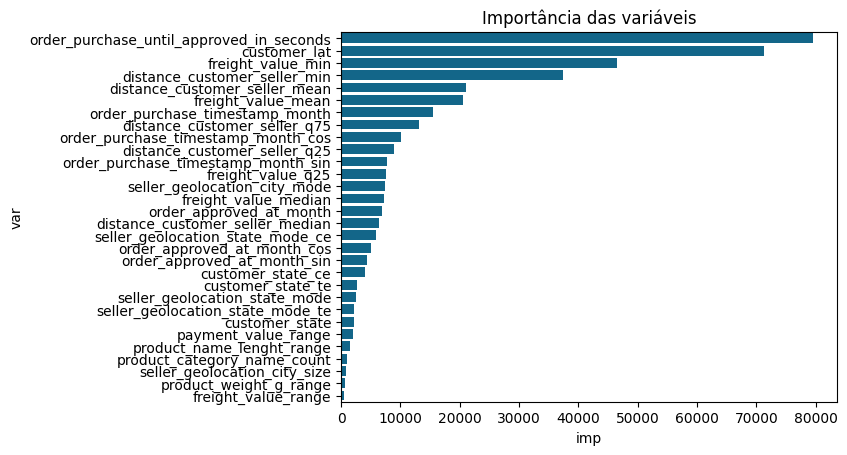

In [88]:
imp = pd.DataFrame(lgbm.feature_importances_, X_train[list_selected_features].columns).reset_index()
imp.columns = ["var", "imp"]
imp = imp.sort_values("imp", ascending=False)

sns.barplot(x="imp", y="var", color="#006e9cff", data=imp.iloc[:30])

plt.title(f"Importância das variáveis")
plt.show()

### Shap Values

In [89]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train[list_selected_features])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


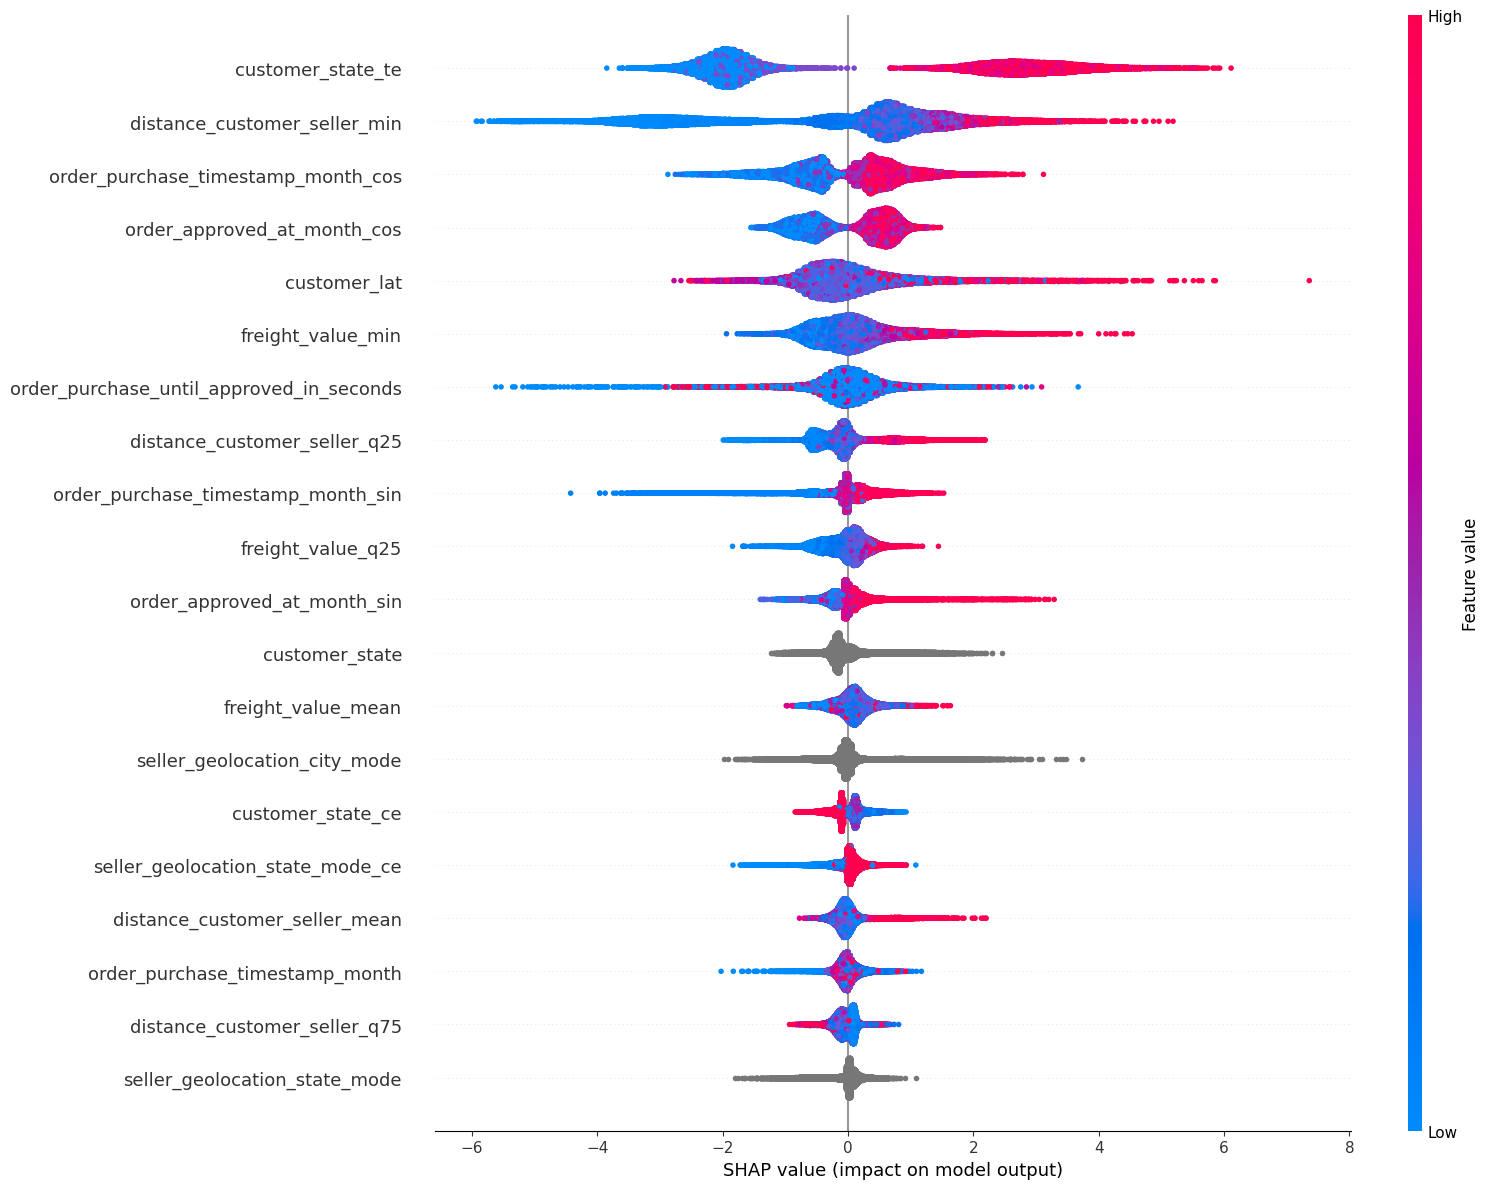

,index,impact
33,customer_state_te,2.343690
5,distance_customer_seller_min,1.410126
37,order_purchase_timestamp_month_cos,0.685233
39,order_approved_at_month_cos,0.610277
1,customer_lat,0.524721
17,freight_value_min,0.475880
27,order_purchase_until_approved_in_seconds,0.342835
8,distance_customer_seller_q25,0.335695
36,order_purchase_timestamp_month_sin,0.318544
20,freight_value_q25,0.241942


In [90]:
shap.summary_plot(shap_values, X_train[list_selected_features], plot_size=(16, 12))

shap_df = pd.DataFrame(np.abs(shap_values), columns=list_selected_features)
shap_df = (
    pd.DataFrame(shap_df.mean(), columns=["impact"]).reset_index()
    .rename(columns={"level_0": "var"})
    .sort_values(by=["impact"], ascending=False))

display(shap_df.head(15))

## Analysis of Estimated Values

### Train Values

In [91]:
get_metrics(y_train[target], y_train['estimated_delivery_in_days'])

R2: -1.2710958645968153; RMSE: 15.15362181073755; MAE: 12.798987749467994; MAPE: 63632846865898.91


In [92]:
get_metrics(y_train[target], y_train['pred'])

R2: 0.48625332715217573; RMSE: 7.207310331366673; MAE: 4.333385075738612; MAPE: 16657133896335.045


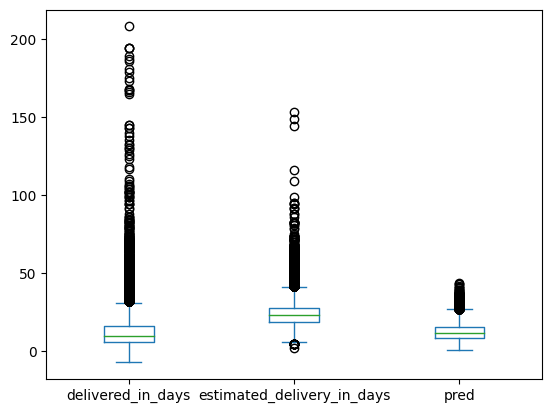

In [93]:
y_train.plot(kind='box');

### Valid Values

In [94]:
get_metrics(y_valid[target], y_valid['estimated_delivery_in_days'])

R2: -1.3023139893957243; RMSE: 14.932066313490298; MAE: 12.686517203798848; MAPE: 58722788228598.95


In [95]:
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.30514296024216525; RMSE: 8.203238997156827; MAE: 5.126536932213392; MAPE: 17209577139753.117


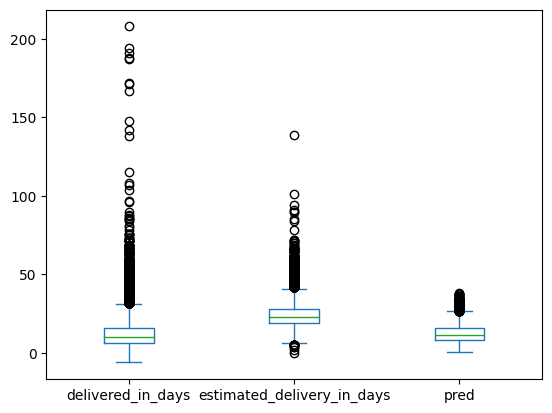

In [96]:
y_valid.plot(kind='box');

### OoT Values

In [97]:
get_metrics(y_oot[target], y_oot['estimated_delivery_in_days'])

R2: -6.096547120243494; RMSE: 15.469371569468713; MAE: 12.755738321776057; MAPE: 243542505248334.34


In [98]:
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.023334845719112485; RMSE: 5.874325496394716; MAE: 4.415642258807508; MAPE: 111399185941927.78


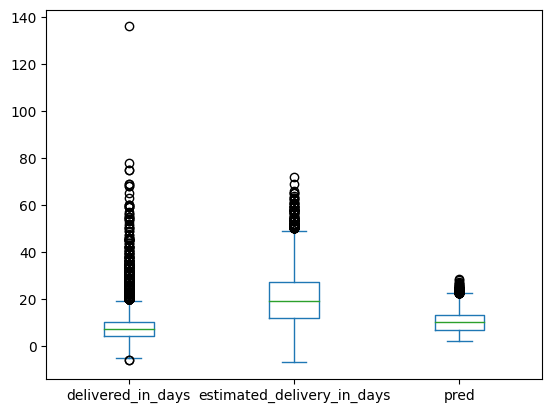

In [99]:
y_oot.plot(kind='box');

### Metrics over Time

In [100]:
df_aux = pd.concat([df_valid[['time']], df_oot[['time']]], axis=0)
df_aux1 = pd.concat([y_valid, y_oot], axis=0)

df_aux = pd.concat([df_aux, df_aux1], axis=1)

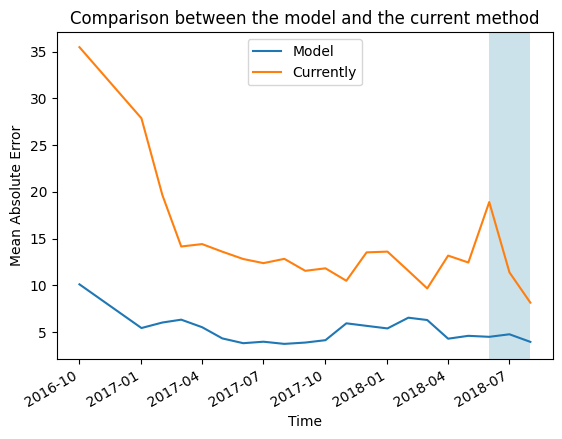

In [101]:
df_aux.groupby('time').apply(lambda i: mean_absolute_error(i[target], i['pred'])).plot(label='Model')
df_aux.groupby('time').apply(lambda i: mean_absolute_error(i[target], i['estimated_delivery_in_days'])).plot(label='Currently')

plt.axvspan("2018-06-01", "2018-08-01", facecolor="#006e9cff", alpha=0.2)

plt.title('Comparison between the model and the current method')
plt.xlabel('Time')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best');

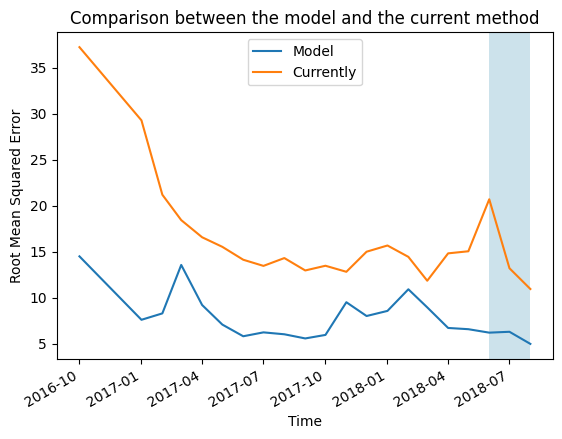

In [102]:
df_aux.groupby('time').apply(lambda i: mean_squared_error(i[target], i['pred'], squared=False)).plot(label='Model')
df_aux.groupby('time').apply(lambda i: mean_squared_error(i[target], i['estimated_delivery_in_days'], squared=False)).plot(label='Currently')

plt.axvspan("2018-06-01", "2018-08-01", facecolor="#006e9cff", alpha=0.2)

plt.title('Comparison between the model and the current method')
plt.xlabel('Time')
plt.ylabel('Root Mean Squared Error')
plt.legend(loc='best');